In [6]:
import matplotlib . pyplot as plt
import numpy as np
from matplotlib . colors import LogNorm
import pandas as pd
import seaborn as sns
import random
from sklearn . cluster import KMeans
from sklearn import metrics
from collections import Counter
#% matplotlib inline
import sys , os , pickle

# Plots stuff
import matplotlib as mpl
from matplotlib . backends . backend_pdf import PdfPages
from matplotlib import patches
mpl.rcParams["font.family"] = ["Garuda"]
mpl.rcParams["font.serif"] = ["Garuda-Oblique"]
def flatten_list ( listoflist ) :
    listoflist_fl = [];
    for l in range (len(listoflist)):
        for u in range (len(listoflist[l])):
            listoflist_fl.append(listoflist[l][u])
    return listoflist_fl


from sonia.plotting import Plotter
from sonia.evaluate_model import EvaluateModel
from sonia.sequence_generation import SequenceGeneration
from sonnia.processing import Processing


In [7]:
## here I take a sublist  of  labels I am  interested in, for  instance  theones
# ## used in  TCRdist  paper , see: https :// pubmed.ncbi.nlm.nih.gov /33398288/


list_labels_tcrdist = [ "AFPFTIYSL ,GYINVFAFPF ,INVFAFPFTI ,MGYINVFAF ,NVFAFPFTI,NVFAFPFTIY ,YINVFAFPF",
                        "FFSNVTWFH , FLPFFSNVT , LPFFSNVTW , LPFFSNVTWF , PFFSNVTWF , SNVTWFHAI",
                        "FLNGSCGSV ", "FLPRVFSAV", "FLWLLWPVT , FLWLLWPVTL , LWLLWPVTL , LWPVTLACF , TLACFVLAAV , WLLWPVTLA , WPVTLACFVL",
                        "FVDGVPFVV ", "HTTDPSFLGRY ","ILGTVSWNL , SNEKQEILGTVSW",
                        "KAYNVTQAF ", "KLSYGIATV ","LLDDFVEII , LLLDDFVEI",
                        "LSPRWYFYY , SPRWYFYYL ", "MVMCGGSLYV , VMCGGSLYV",
                        "MWSFNPETNI , SFNPETNIL , SMWSFNPET",
                        "SEHDYQIGGYTEKW , YQIGGYTEK , YQIGGYTEKW",
                        "TLIGDCATV ", "TVLSFCAFA , VLSFCAFAV",
                        "VLWAHGFEL ", "YLQPRTFL , YLQPRTFLL , YYVGYLQPRTF"]





In [8]:
# select a random sample without replacement
from random import seed
from random import sample
# seed random number generator
seed(2)
# select a subset without replacement
subset = sample(list_labels_tcrdist , 6)
print(subset)
list_peps = subset
what_peps = "sameTCRdist" 
## just a variable to denote why I have chosen that set of labels
import pandas as pd
## this one contains the MIRA data , i.e. associations TCR - peptides ##
ff = pd.read_csv("peptide-detail-ci.csv", sep =",")
list_peps0 = list(ff["Amino Acids"].values) ## The ’label ’, i.e. the peptide specificity
tcrs = list(ff["TCR BioIdentity"].values) ## Receptor identity ##
## Here I simply verify that the sublist of peptides chosen is in the MIRA file ##
list_peps_full = []
for U in range(len(list_peps)) :
    pep = list_peps[U]
    for y in range (len(list_peps0)) :
        if pep in list_peps0[y] and list_peps0[y] not in list_peps_full : 
            ##line to select specificity ##
            list_peps_full.append(list_peps0[y])

list_spec_full =[]
lens =0
for pp in range (len(list_peps_full)) :
    pep = list_peps_full[pp]
    list_spec = []
    for y in range (len(list_peps0)) :
        if pep == list_peps0[y] and tcrs[y] not in list_spec:
            list_spec.append(tcrs[y])
    list_spec_full.append(list_spec) 
    ## Here : groups of TCRs divided by specificity
    lens += len(list_spec) 
    ## overall amount of TCRs specific to the peptides
    print(len(list_spec))

list_spec_full_fl = flatten_list(list_spec_full)
## the difficulty is that 1 seq responds to more than 1 peptide ##
## so here we find TCRs with double specificity assignment ##
## Filter the selected data , retain only the uniquely labelled ones and produce the final tables ##
SAmin = 6 ## Minimal TCR length
cdr3_full = []
listv_full = []
listj_full = []
for uu in range (len(list_spec_full)):
    cdr3 =[]
    listv =[]
    listj =[]
    for u in range(len(list_spec_full[uu])):
        seq1 = (list_spec_full[uu])[u]
        strT = seq1.split("+")
        if len(strT [0]) > SAmin:
            cdr3.append(strT[0])
            listv.append(strT[1])
            listj.append(strT[2])
    cdr3_full.append(cdr3)
    listv_full.append(listv)
    listj_full.append(listj)
    
cdr3_fl = flatten_list(cdr3_full)
listv_fl = flatten_list(listv_full)
listj_fl = flatten_list(listj_full)
print(len(cdr3_fl))
print(len(listv_fl))
print(len(listj_fl))
## For  the  filtering , I use a processing  function  uploaded  from  the  package soNNia
## We  remove  also  TCR  with  wrong  anchor  sites (likely  to be non -functional)and  too  long  sequences
full_tablep = [cdr3_fl , listv_fl , listj_fl]
names = ["amino_acid","v_gene","j_gene"]
dataf = {names[f]:  full_tablep[f] for f in range(len(names))}
df_n = pd.DataFrame(dataf , columns = names)
df_n.to_csv("prova.csv", index=None)
data_seqs = pd.read_csv("prova.csv")
processor = Processing(chain_type = "humanTRB")
filtered = processor.filter_dataframe(data_seqs)
data_seqs = list(filtered.values.astype(np.str)) ## filtered  sequences  arenow  only  the  functional  ones ##
## Once  the  filtering  is done , redefine  clusters  and  labels
labelsM =[]
for i in range(len(data_seqs)):
    temp =[]
    for y in range(len(cdr3_full)):
        if  data_seqs[i][0] in  cdr3_full[y]:
            temp.append(list_peps_full[y])
    labelsM.append(temp)
            
## Here we can  extract  only  the  sublist (indices  in ’indu ’) of TCRs  thatare  associated  to only 1 specificity
labelsM_u = [labelsM[i] for i in  range(len(labelsM)) if len(labelsM[i]) ==1]
indu = [i for i in range(len(labelsM)) if len(labelsM[i]) == 1]
list_labels=list(np.unique(labelsM_u))
labelsM_un =[]
for h in  labelsM_u:
    labelsM_un.append(list_labels.index(h[0]))
    ## Final  result:
    ## data_seqs  -> final  table  of TCR  sequences  with  their V and J segment
    ## labelsM  -> it is the  list of  labels  for  each  TCR
    ## labelsM_u  -> it is the  list of  labels  for  each TCR , retaining  only  TCRswith 1 specificity

['FFSNVTWFH , FLPFFSNVT , LPFFSNVTW , LPFFSNVTWF , PFFSNVTWF , SNVTWFHAI', 'FLNGSCGSV ', 'VLWAHGFEL ', 'LSPRWYFYY , SPRWYFYYL ', 'MWSFNPETNI , SFNPETNIL , SMWSFNPET', 'TVLSFCAFA , VLSFCAFAV']
0
0
0
bad genes: 0


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
len(ff["Amino Acids"].unique())

269

In [9]:
ff

,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome
0,CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073
1,CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02,CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...,eOX56,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073
2,CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,GAGATCCAGTCCACGGAGTCAGGGGACACAGCACTGTATTTCTGTG...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073
3,CALKVGADTQYF+TCRBV30-01+TCRBJ02-03,CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...,eQD124,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073
4,CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073
...,...,...,...,...,...,...,...
154315,CASSQLPGQGKVQYF+TCRBV04-01+TCRBJ02-07,CACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCGCCAGCA...,eAV93,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668
154316,CASSPGDNEQFF+TCRBV09-01+TCRBJ02-01,CTAAACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCT...,eEE224,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668
154317,CASSVGDPDTQYF+TCRBV09-01+TCRBJ02-03,AACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCTGTG...,eAV88,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668
154318,CASSYYSYNEQFF+TCRBV27-01+TCRBJ02-01,ATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTG...,eEE224,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668


In [10]:
ff = pd.read_csv("peptide-detail-ci.csv", sep =",")
ff = ff.sample(10000)
ff
# Which columns can I use ? Only TCR BioIdentity and Amino Acids?
# Do V and J genes matter? I think not, since I am not interested in the TCRs themselves, but in the peptides they bind to ?

,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome
6582,unproductive+TCRBV05-06+TCRBJ02-07,GAATGTGAACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGT...,eMR17,ORF1ab,HTTDPSFLGRY,5171,5203
32294,CSARDGTGDEQYF+TCRBV20-X+TCRBJ02-07,ACAGTGACCAGTGCCCATCCTGAAGACAGCAGCTTCTACATCTGCA...,eAV91,ORF1ab,MPASWVMRI,11228,11254
121858,CASSLQGSYNSPLHF+TCRBV05-08+TCRBJ01-06,AACGCCTTGGAGCTGGAGGACTCGGCCCTGTATCTCTGTGCCAGCA...,eOX49,ORF7b,"AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYL...",27756,27830
21624,CASSFGGSNEQFF+TCRBV27-01+TCRBJ02-01,ATCCTGGAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTG...,eXL31,ORF1ab,"QLMCQPILL,QLMCQPILLL",7952,7981
52471,CASSVGGDYEQYF+TCRBV09-01+TCRBJ02-07,AACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCTGTG...,eEE228,ORF1ab,VLWAHGFEL,18590,18616
...,...,...,...,...,...,...,...
97819,CSVARHRAGNYGYTF+TCRBV29-01+TCRBJ01-02,AGCAACATGAGCCCTGAAGACAGCAGCATATATCTCTGCAGCGTCG...,eXL31,membrane glycoprotein,WICLLQFAY,26613,26639
10260,CASTLEGDQPQHF+TCRBV28-01+TCRBJ01-05,ATTCTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTG...,eMR13,ORF1ab,HTTDPSFLGRY,5171,5203
83219,CASSVDRAGHSYNEQFF+TCRBV09-01+TCRBJ02-01,CTGGAGCTGGGGGACTCAGCTTTGTATTTCTGTGCCAGCAGCGTAG...,eXL27,surface glycoprotein,"CMTSCCSCLK,MTSCCSCLK",25268,25297
146752,CASSHILQGFGNTIYF+TCRBV03-01/03-02+TCRBJ01-03,TCCCTGGAGCTTGGTGACTCTGCTGTGTATTTCTGTGCCAGCAGCC...,eMR15,nucleocapsid phosphoprotein,"AYKTFPPTEPK,KTFPPTEPK",29348,29380


In [11]:
from tqdm.notebook import tqdm
for i in tqdm(ff.index):
    ff.loc[i,"nb_amino_acids"] = len(str(ff.loc[i,"Amino Acids"]).split(","))
    ff.loc[i, "cdr3"] = str(ff.loc[i,"TCR BioIdentity"]).split("+")[0]
    ff.loc[i, "len_cdr3"] = len(str(ff.loc[i, "cdr3"]))

  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:>

findfont: Font family ['Garuda'] not found. Falling back to DejaVu Sans.


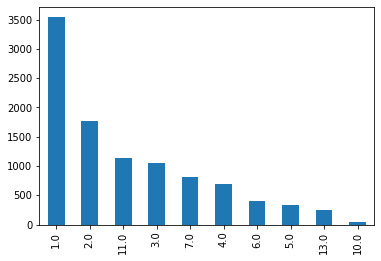

In [12]:
ff["nb_amino_acids"].value_counts().plot( kind='bar')
# Should I consider all the amino acids or only the ones that bind to one peptide ?

<AxesSubplot:>

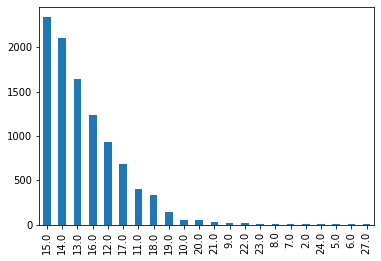

In [13]:
ff["len_cdr3"].value_counts().plot( kind='bar')
# No alignment process needed ? => Goal is to not use the alignment process

In [14]:
ff2 = pd.read_csv("peptide-detail-cii.csv", sep =",")
ff2

,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome
0,CASSGSSQGPLWETQYF+TCRBV05-06+TCRBJ02-05,TTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCAGCGGGT...,eLH58,surface glycoprotein,"KVFRSSVLHSTQDLFLPFF,MFVFLVLLPLVSSQCVNLT,NLTTRT...",21563,21739
1,CARRAADTQYF+TCRBV02-01+TCRBJ02-03,NCTCTGAAGATCCGGTCCACAAAGCTGGAGGACTCAGCCATGTACT...,eNL187,surface glycoprotein,"KVFRSSVLHSTQDLFLPFF,MFVFLVLLPLVSSQCVNLT,NLTTRT...",21563,21739
2,CATSRGVSGYTF+TCRBV19-01+TCRBJ01-02,CTCACTGTGACATCGGCCCAAAAGAACCCGACAGCTTTCTATCTCT...,eNL187,surface glycoprotein,"KVFRSSVLHSTQDLFLPFF,MFVFLVLLPLVSSQCVNLT,NLTTRT...",21563,21739
3,CASSPGTGDYEQYF+TCRBV05-01+TCRBJ02-07,GTGAGCACCTTGGAGCTGGGGGACTCGGCCCTTTATCTTTGCGCCA...,eNL192,surface glycoprotein,"KVFRSSVLHSTQDLFLPFF,MFVFLVLLPLVSSQCVNLT,NLTTRT...",21563,21739
4,CSARGQYSNQPQHF+TCRBV20-X+TCRBJ01-05,GTGACCAGTGCCCATCCTGAAGACAGCAGCTTCTACATCTGCAGTG...,eNL187,surface glycoprotein,"KVFRSSVLHSTQDLFLPFF,MFVFLVLLPLVSSQCVNLT,NLTTRT...",21563,21739
...,...,...,...,...,...,...,...
6804,CASSPRGGGPPKEQYF+TCRBV12-X+TCRBJ02-07,CCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCAGTC...,eQD139,nucleocapsid phosphoprotein,"DETQALPQRQKKQQTVTLL,KKDKKKKADETQALPQRQK,KTFPPT...",29354,29530
6805,CSGGGVSNEQFF+TCRBV20-X+TCRBJ02-01,CTGACAGTGACCAGTGCCCATCCTGAAGACAGCAGCTTCTACATCT...,eAV100,ORF10,"FPFTIYSLLLCRMNSRNYI,LLCRMNSRNYIAQVDVVNFNLT,MGY...",29558,29671
6806,CASSSEVGGEQFF+TCRBV18-01+TCRBJ02-01,AGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCTGTG...,eNL189,ORF10,"FPFTIYSLLLCRMNSRNYI,LLCRMNSRNYIAQVDVVNFNLT,MGY...",29558,29671
6807,CASSLVWTGGAYEQYF+TCRBV07-02+TCRBJ02-07,CGCACACAGCAGGAGGACTCGGCCGTGTATCTCTGTGCCAGCAGCT...,eNL189,ORF10,"FPFTIYSLLLCRMNSRNYI,LLCRMNSRNYIAQVDVVNFNLT,MGY...",29558,29671


In [18]:
from DeepTCR.DeepTCR import DeepTCR_U
import sys
sys.path.append('./DeepTCR-master/')
# Instantiate training object
DTCRU = DeepTCR_U('Tutorial')

#Load Data from directories
DTCRU.Get_Data(directory='./DeepTCR-master/Data/Murine_Antigens',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=0,count_column=1,v_beta_column=2,j_beta_column=3)

#Train VAE
DTCRU.Train_VAE(Load_Prev_Data=False)

Loading Data...
Embedding Sequences...
Data Loaded


C:\Users\yanis\AppData\Roaming\Python\Python38\site-packages\DeepTCR\functions\Layers.py:105: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv = tf.compat.v1.layers.conv2d(inputs, units[ii], (1, kernel), 1, padding='same',
C:\Users\yanis\AppData\Roaming\Python\Python38\site-packages\keras\legacy_tf_layers\convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\yanis\AppData\Roaming\Python\Python38\site-packages\DeepTCR\functions\Layers.py:107: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  conv_out = tf.compat.v1.layers.flatten(tf.reduce_max(input_tensor=conv, axis=2))
C:\Users\yanis\AppData\Roaming\Python\Python38\site-packages\keras\legacy_tf_layers\core.py:523: UserWarning: `laye

Epoch = 0, Iteration = 0 Total Loss: 8.42992: Recon Loss: 8.34857: Latent Loss: 0.08135: Sparsity Loss: 0.00000: Recon Accuracy: 0.04557
Epoch = 1, Iteration = 0 Total Loss: 8.05984: Recon Loss: 7.97965: Latent Loss: 0.08019: Sparsity Loss: 0.00000: Recon Accuracy: 0.06574
Epoch = 2, Iteration = 0 Total Loss: 7.79562: Recon Loss: 7.71554: Latent Loss: 0.08008: Sparsity Loss: 0.00000: Recon Accuracy: 0.09090
Epoch = 3, Iteration = 0 Total Loss: 7.56441: Recon Loss: 7.48249: Latent Loss: 0.08192: Sparsity Loss: 0.00000: Recon Accuracy: 0.11320
Epoch = 4, Iteration = 0 Total Loss: 7.39459: Recon Loss: 7.30462: Latent Loss: 0.08997: Sparsity Loss: 0.00000: Recon Accuracy: 0.13941
Epoch = 5, Iteration = 0 Total Loss: 7.27428: Recon Loss: 7.16255: Latent Loss: 0.11174: Sparsity Loss: 0.00000: Recon Accuracy: 0.16085
Epoch = 6, Iteration = 0 Total Loss: 7.15128: Recon Loss: 7.00802: Latent Loss: 0.14326: Sparsity Loss: 0.00000: Recon Accuracy: 0.18868
Epoch = 7, Iteration = 0 Total Loss: 6.96

In [19]:
%%capture
DTCRU.Train_VAE(Load_Prev_Data=False,sparsity_alpha=1.0,var_explained = 0.99)

INFO:tensorflow:Tutorial\models\model_0\model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


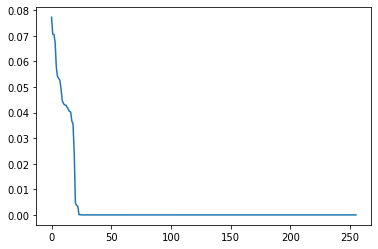

In [20]:
plt.plot(DTCRU.explained_variance_ratio_)

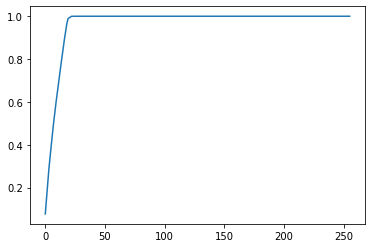

In [21]:
plt.plot(np.cumsum(DTCRU.explained_variance_ratio_))